In [149]:
import os
from pydicom import dcmread
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from operator import itemgetter
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
import pydicom
from dpipe.io import save, load
from pathlib import Path
import warnings
import numpy as np
from tqdm import tqdm
from skimage.draw import polygon
import pydicom
from dpipe.io import load, save

## Load table with meta data

In [150]:
df = pd.read_excel('/nmnt/media/home/donskovamariya/dataset/data_new.xlsx')

/nmnt/media/home/donskovamariya/miniconda3/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [151]:
df.head()

,Unnamed: 0,Нумерация пациентов,Пол,Возраст,Рост (м),Вес (кг),ИМТ,Normal/LowDose,AccessionNumber,ID ЕРИС,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,0,1,ж,49,1.71,80,27.36,1,RLA7841002030535,1.2.392.200036.9116.2.5.1.37.2424352785.158675...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,ж,49,1.71,80,27.36,1,RLA7841002030535,1.2.392.200036.9116.2.5.1.37.2424352785.158675...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,ж,49,1.71,80,27.36,0,RLA7841002030535,1.2.392.200036.9116.2.5.1.37.2424352785.158675...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,ж,49,1.71,80,27.36,0,RLA7841002030535,1.2.392.200036.9116.2.5.1.37.2424352785.158675...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2,ж,45,1.65,56,20.57,1,RLA7841002029705,1.2.392.200036.9116.2.5.1.37.2424352785.158673...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
df.iloc[0, 1:10] == df.iloc[1, 1:10]

Нумерация пациентов    True
Пол                    True
Возраст                True
Рост (м)               True
Вес (кг)               True
ИМТ                    True
Normal/LowDose         True
AccessionNumber        True
ID ЕРИС                True
dtype: bool

In [153]:
df.columns

Index(['Unnamed: 0', 'Нумерация пациентов', 'Пол', 'Возраст', 'Рост (м)',
       'Вес (кг)', 'ИМТ', 'Normal/LowDose', 'AccessionNumber', 'ID ЕРИС',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
       'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33',
       'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36'],
      dtype='object')

In [154]:
len(np.unique(df.AccessionNumber))

230

In [155]:
len(np.unique(df['ID ЕРИС']))

230

In [156]:
np.unique(df['Пол'])

array(['ж', 'м'], dtype=object)

In [157]:
np.unique(df['Рост (м)'])

array([  1.52,   1.53,   1.54,   1.55,   1.56,   1.57,   1.58,   1.59,
         1.6 ,   1.62,   1.63,   1.64,   1.65,   1.66,   1.67,   1.68,
         1.69,   1.7 ,   1.71,   1.72,   1.73,   1.75,   1.76,   1.77,
         1.78,   1.79,   1.8 ,   1.82,   1.83,   1.84,   1.85,   1.86,
         1.87,   1.88,   1.89,   1.9 , 176.  ])

In [158]:
df = df.replace(176., 1.76)

In [159]:
np.unique(df['Рост (м)'])

array([1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.62, 1.63,
       1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.75,
       1.76, 1.77, 1.78, 1.79, 1.8 , 1.82, 1.83, 1.84, 1.85, 1.86, 1.87,
       1.88, 1.89, 1.9 ])

#### Load example from raw dataset

In [114]:
bath_path = '/nmnt/x1-storage/raw/Dicom'
hct = 'Chest HCT'
ct = 'Chest CT for COVID-19'
N = 0
a = []
for path_ in os.listdir(bath_path):
    path = os.path.join(bath_path, path_)
    example = os.path.join(path, ct)
    path_to_dicoms = os.path.join(example, os.listdir(example)[0])
    path_to_dicom = os.path.join(path_to_dicoms, os.listdir(path_to_dicoms)[N])
    dicom = dcmread(path_to_dicom)
    break

In [115]:
base_path = Path('/nmnt/x1-storage/raw')
joined = pd.read_csv(base_path / 'joined.csv')

In [167]:
from dicom_csv import *

In [18]:
images = aggregate_images(joined, ['SeriesInstanceUID'])

In [19]:
images.StudyInstanceUID.value_counts()

1.2.643.5.1.13.13.12.2.77.8252.527215567973585.457433714561925.    6
1.2.643.5.1.13.13.12.2.77.8252.601015210670323.556816671255315.    5
1.2.643.5.1.13.13.12.2.77.8252.842101220242535.217102407148216.    5
1.2.643.5.1.13.13.12.2.77.8252.657061416754362.523130301554526.    5
1.2.643.5.1.13.13.12.2.77.8252.006596534162752.581535423392398.    5
                                                                  ..
1.2.643.5.1.13.13.12.2.77.8252.930810936605035.519021604210220.    5
1.2.643.5.1.13.13.12.2.77.8252.269696027057193.439390378556722.    5
1.2.643.5.1.13.13.12.2.77.8252.277501643264001.277733216732794.    5
1.2.643.5.1.13.13.12.2.77.8252.300230125074341.303668647093104.    5
1.2.643.5.1.13.13.12.2.77.8252.925012564411454.708055215043588.    5
Name: StudyInstanceUID, Length: 230, dtype: int64

In [20]:
images.AccessionNumber.value_counts()

RLADD02003985408    6
RLADD02003982578    5
RLA7841002037930    5
RLA7841002049594    5
RLADD02003971653    5
                   ..
RLA7841002038140    5
RLADD02003971445    5
RLADD02003984893    5
RLA7841002035470    5
RLADD02003980289    5
Name: AccessionNumber, Length: 230, dtype: int64

In [124]:
for _, row in images.iterrows():
    print(row.PathToFolder)

RLP0F54003278685/RLADD02003982417_RLSDD02003933286
RLP0F54003836579/Chest CT for COVID-19/RLA7841002046104_RLS7841002046104
RLP0F54003828171/Chest HCT/RLADD02003980810_RLSDD02003932685
RLP0F54003821555/Chest HCT/RLADD02003982357_RLSDD02003933039
RLP0F54003830709/RLADD02003982703_RLSDD02003933489
RLP0F54003831284/Chest  HCT/RLA7841002050258_RLS7841002050258
RLP0F54003831642/RLA7841002050620_RLS7841002050620
RLP0F5400607129/Chest HCT/RLADD02003980742_RLSDD02003932537
RLP0F54003829953/Chest HCT/RLADD02003982084_RLSDD02003932966
RLP0F5400433378/Chest CT for COVID-19/RLADD02003980396_RLSDD02003932090
RLP0F54003801380/Chest CT for COVID-19/RLA7841002041849_RLS7841002041849
RLP0F54003821482/RLADD02003982321_RLSDD02003933002
RLP0F54003826120/RLADD02003980092_RLSDD02003930919
RLP0F54003830780/Chest CT for COVID-19/RLADD02003982733_RLSDD02003933419
RLP0F54003838579/Chest CT for COVID-19/RLA7841002049352_RLS7841002049352
RLP0F54003830414/Chest HCT/RLADD02003982620_RLSDD02003933397
RLP0F5400170984

In [135]:
index = []
for i in range(images.shape[0]):
    if len(images.loc[i, 'PathToFolder'].split('/')) != 2:
        index.append(i)
print(len(index))

920


In [136]:
df.shape[0]

920

In [137]:
images.shape[0] - a

920

In [140]:
images = images[images.index.isin(index)]

In [141]:
images.shape

(920, 105)

In [160]:
def get_weight(x):
    return int(np.unique(df[df['AccessionNumber'] == x.iloc[0]]['Вес (кг)'])[0])

def get_height(x):
    return int(100 * np.unique(df[df['AccessionNumber'] == x.iloc[0]]['Рост (м)'])[0])

def get(x):
    return np.unique(df[df['AccessionNumber'] == x.iloc[0]]['Пол'])[0]

images['Age'] = [int(row.PatientAge[1:-1]) for _, row in images.iterrows()]
#images['Sex'] = [row.PatientSex for _, row in images.iterrows()]

images['Sex'] = images[['AccessionNumber']].apply(lambda x: get(x), axis=1)
images['Weight'] = images[['AccessionNumber']].apply(lambda x: get_weight(x), axis=1)
images['Height'] = images[['AccessionNumber']].apply(lambda x: get_height(x), axis=1)

<ipython-input-160-4a28b8a76d03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  images['Age'] = [int(row.PatientAge[1:-1]) for _, row in images.iterrows()]
<ipython-input-160-4a28b8a76d03>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  images['Sex'] = images[['AccessionNumber']].apply(lambda x: get(x), axis=1)
<ipython-input-160-4a28b8a76d03>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [161]:
images

,AccessionNumber,AcquisitionDate,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConversionType,HighBit,InstanceCreationDate,InstitutionAddress,...,StackID,TableHeight,TemporalPositionIndex,Exposure,XRayTubeCurrent,PatientWeight,Age,Sex,Weight,Height
1,RLA7841002046104,20200324,16,16,CHEST,512,NaN,15,20200324,http://medradiology.moscow,...,1_0589_00004,65.0,1.0,NaN,NaN,NaN,49,м,90,176
2,RLADD02003980810,20200422,16,16,CHEST,512,NaN,15,20200422,http://medradiology.moscow,...,1_0173_00002,51.0,1.0,NaN,NaN,NaN,43,ж,66,162
3,RLADD02003982357,20200329,16,16,CHEST,512,NaN,15,20200329,http://medradiology.moscow,...,1_0193_00001,83.0,1.0,NaN,NaN,NaN,47,ж,85,160
5,RLA7841002050258,20200325,16,16,CHEST,512,NaN,15,20200325,http://medradiology.moscow,...,1_0648_00002,72.0,1.0,250.0,500.0,NaN,28,м,110,179
7,RLADD02003980742,20200330,16,16,NaN,512,NaN,15,20200330,http://medradiology.moscow,...,1_0153_00002,74.0,1.0,NaN,NaN,NaN,62,м,91,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,RLA7841002047900,20200324,16,16,CHEST,512,NaN,15,20200324,http://medradiology.moscow,...,1_0596_00001,77.0,1.0,NaN,NaN,NaN,56,ж,89,170
1147,RLA7841002035373,20200429,16,16,CHEST,512,NaN,15,20200429,http://medradiology.moscow,...,1_0468_00003,97.0,1.0,NaN,NaN,NaN,59,ж,60,164
1148,RLADD02003982578,20200405,16,16,CHEST,512,NaN,15,20200405,http://medradiology.moscow,...,1_0208_00004,102.0,1.0,NaN,NaN,NaN,53,ж,70,167
1149,RLA7841002050564,20200512,16,16,CHEST,512,NaN,15,20200512,http://medradiology.moscow,...,1_0652_00003,97.0,1.0,NaN,NaN,NaN,32,ж,56,172


<AxesSubplot:>

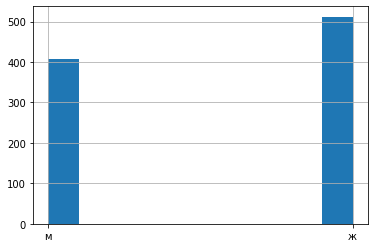

In [163]:
images['Sex'].hist()

<AxesSubplot:>

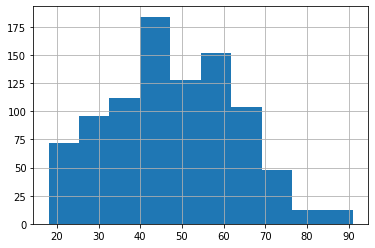

In [164]:
images['Age'].hist()

<AxesSubplot:>

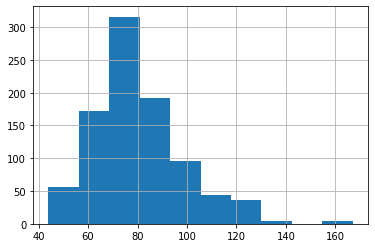

In [165]:
images['Weight'].hist()

<AxesSubplot:>

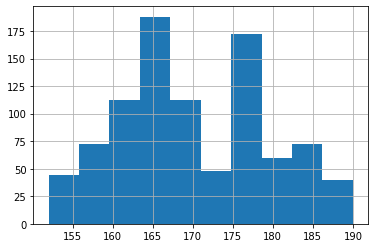

In [166]:
images['Height'].hist()

In [21]:
def add_image(buffer_path, series_uid, image, spacing, study_uid, accession_number, age, sex, weight, height):
    assert isinstance(series_uid, str), '``series_uid`` must be a string.'
    assert isinstance(image, np.ndarray), '``image`` must be a numpy array.'
    assert image.dtype == np.int16
    assert isinstance(spacing, tuple) or isinstance(spacing, list), '``pixel_spacing`` must be tuple or list'
    assert len(spacing) == 3, '``pixel_spacing`` must be of length 3.'
    assert isinstance(study_uid, str), '``study_uid`` must be a string.'

    path = Path(buffer_path) / 'image' / series_uid
    assert not path.exists(), f'{path} already exists.'
    path.mkdir(parents=True)
    save(image, path / 'data.npy.gz', compression=1, timestamp=0)
    save(image.shape, path / 'shape.json')
    save(spacing, path / 'spacing.json')
    save(study_uid, path / 'study_uid.json')
    save(image.shape, path / 'accession_number.json')
    save(spacing, path / 'age.json')
    save(study_uid, path / 'sex.json')
    save(study_uid, path / 'weight.json')
    save(study_uid, path / 'height.json')

In [ ]:
for index, row in tqdm(images.iterrows()):
    dicoms = disk.load(
        [base_path / 'tree' / row.PathToFolder / file for file in row.FileNames.split('/')],
        loader=pydicom.dcmread
    )
    dicoms = order_series(dicoms)
    x = stack_images(dicoms, -1)
    
    add_image(
        OUTPUT, dicoms[0].SeriesInstanceUID, x, 
        get_voxel_spacing(dicoms), dicoms[0].StudyInstanceUID,  dicoms[0].AccessionNumber,
        row.Age, row.Sex, row.Weight, row.Height
        
    )